# 観光入込客数の分析

In [241]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model
import sklearn.model_selection
import matplotlib.pyplot as plt
%matplotlib inline

## 1. sheet1, 2, 4, 5の加工用関数の定義

In [202]:
h26_files = ["data/H26-{0}.xlsx".format(i) for i in range(1, 5)]
h27_files = ["data/H27-{0}.xlsx".format(i) for i in range(1, 5)]
h28_files = ["data/H28-{0}.xlsx".format(i) for i in range(1, 5)]
h29_files = ["data/H29-{0}.xlsx".format(i) for i in range(1, 5)]

In [237]:
def process_files1(files):
    '''''sheet1の加工'''
    
    col_names = ["都道府県", "県内_宿泊", "県内_日帰り", "県外_宿泊", "県外_日帰り", "消費1", "消費2", "消費3", "消費4" ]
    df = pd.DataFrame()
    
    for file in files:
        temp = pd.read_excel(file, sheet_name=1, skiprows=6, skipfooter=1, usecols=range(9),
                            names=col_names,  index_col=0, na_values=["集計中", "-"])
        temp.reset_index(inplace=True)
        if not df.empty: df = pd.concat([df, temp], ignore_index=True)
        else: df = temp 
    
    df = df.dropna(how="any")
    df["都道府県"] = df["都道府県"].str[3:]
    df["消費額単価"] =  df["消費1"] + df["消費2"] + df["消費3"] + df["消費4"]
    df.drop(df.columns[[5, 6, 7, 8]], axis=1, inplace=True)
    df.iloc[:, 1:] = df.iloc[:, 1:].astype(int)
    
    return df

def process_files2(files):
    '''sheet4と5の加工'''

    col_names = ["都道府県", "自然", "歴史・文化", "温泉・健康", "スポーツ・レク", "都市型観光", "イベント"]

    sheet4 = pd.DataFrame()
    use_cols_4 = [0, 3, 4, 5, 6, 7, 10]

    for(i, file) in enumerate(files):
        temp = pd.read_excel(file, sheet_name=4, skiprows=6, skipfooter=1, usecols=use_cols_4, names=col_names, index_col=0)
        temp = temp.stack()
        temp.index.rename("目的", level=1, inplace=True)
        temp.name = "地点数"
        temp = temp.reset_index()
        if not sheet4.empty: sheet4 = pd.concat([sheet4, temp], ignore_index=True)
        else: sheet4 = temp

    sheet5 = pd.DataFrame()
    use_cols_5 = [0, 3, 4, 5, 6, 7, 9]

    for(i, file) in enumerate(files):
        temp = pd.read_excel(file, sheet_name=5, skiprows=6, skipfooter=1, usecols=use_cols_5, names=col_names, index_col=0)
        temp = temp.stack()
        temp.index.rename("目的", level=1, inplace=True)
        temp.name = "客数"
        temp = temp.reset_index()
        if not sheet5.empty: sheet5 = pd.concat([sheet5, temp], ignore_index=True)
        else: sheet5 = temp

    df = pd.DataFrame()
    df = pd.merge(sheet4, sheet5, left_index=True, right_index=True, on=["都道府県", "目的"], how="left")
    df = df.dropna(how="any")
    df["都道府県"] = df["都道府県"].str[3:]
    df.iloc[:, 2:] = df.iloc[:, 2:].astype(int)

    return df

## 2. sheet1, 2, 4, 5の加工

In [238]:
# sheet1&sheet2
h26_jp = process_files1(h26_files)
h27_jp = process_files1(h27_files)
h28_jp = process_files1(h28_files)
h29_jp = process_files1(h29_files)
jp = pd.concat([h26_jp, h27_jp, h28_jp, h29_jp], ignore_index=True)
jp.to_csv("data_after/jp.csv", index=False)

#sheet4&sheet5
h26_resorts = process_files2(h26_files)
h27_resorts = process_files2(h27_files)
h28_resorts = process_files2(h28_files)
h29_resorts = process_files2(h29_files)
resorts = pd.concat([h26_resorts, h27_resorts, h28_resorts, h29_resorts], ignore_index=True)
resorts.to_csv("data_after/resorts.csv", index=False)

## 3. クラスタリング

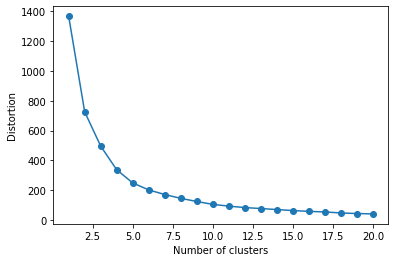

In [196]:
purpose = resorts[resorts.目的=="自然"].iloc[:, [2, 3]] #目的を設定

sc = StandardScaler()
purpose_sc = sc.fit_transform(purpose)

#エルボー法により適切なクラスタ数を調べる
distortions = []
for i  in range(1,21):
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(purpose_sc)
    distortions.append(km.inertia_)

plt.plot(range(1,21),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [197]:
#k-meansでクラスタリング
km = KMeans(n_clusters=5, random_state=0)
clusters = km.fit(purpose_sc)
purpose["cluster"] = clusters.labels_
purpose = pd.merge(purpose, resorts["都道府県"], left_index=True, right_index=True, how="left")
purpose = purpose.iloc[:, [3, 0, 1, 2]]
purpose.reset_index(drop=True, inplace=True)

In [198]:
#岩手県がどのクラスタに分類されたのかを確認
iwate = purpose.loc[purpose["都道府県"] == "岩手県"]
iwate

,都道府県,地点数,客数,cluster
2,岩手県,33,604,1
47,岩手県,33,1226,1
91,岩手県,34,1706,0
135,岩手県,34,914,1
179,岩手県,34,911,1
223,岩手県,35,1406,1
266,岩手県,35,1922,0
309,岩手県,36,969,1
352,岩手県,37,454,1
395,岩手県,37,1204,1


In [199]:
#クラスタごとのデータ数を確認
purpose.groupby("cluster").count()

,都道府県,地点数,客数
cluster,,,
0,90,90,90
1,244,244,244
2,24,24,24
3,53,53,53
4,272,272,272


In [200]:
#クラスタごとの地点数と客数の平均値を算出
purpose_mean = purpose.groupby("cluster").mean()

#1地点あたりの客数の列を追加
purpose_mean["1地点あたりの客数"] = purpose_mean["客数"] / purpose_mean["地点数"]
purpose_mean.sort_values("1地点あたりの客数", ascending=False, inplace=True)
purpose_mean

,地点数,客数,1地点あたりの客数
cluster,,,
2,58.958333,6339.916667,107.532155
0,40.577778,2375.266667,58.536145
4,16.889706,473.720588,28.047889
1,36.553279,789.069672,21.586837
3,80.867925,1514.830189,18.732151


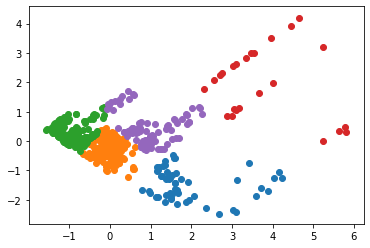

In [201]:
X = purpose_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df["cluster"] = purpose["cluster"]

for i in purpose["cluster"].unique():
    tmp = pca_df.loc[pca_df["cluster"]==i]
    plt.scatter(tmp[0], tmp[1])

## 4. 回帰

In [242]:
model = linear_model.LinearRegression()
X = jp[["県内_宿泊", "県内_日帰り", "県外_宿泊", "県外_日帰り"]]
y = jp["消費額単価"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.3865838558600644
0.37852680036705766
